In [1]:
import numpy as np 
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import cv2
import os
import re
import pydicom
import warnings
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import random
paddingSize= 0
import tensorflow as tf
from tensorflow.keras import Model
from tqdm import notebook

In [2]:
warnings.filterwarnings("ignore")
DIR_INPUT = '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'


In [3]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.fillna(0, inplace=True)
train_df.loc[train_df["class_id"] == 14, ['x_max', 'y_max']] = 1.0

# FasterRCNN handles class_id==0 as the background.
train_df["class_id"] = train_df["class_id"] + 1
train_df.loc[train_df["class_id"] == 15, ["class_id"]] = 0

print("df Shape: "+str(train_df.shape))
print("No Of Classes: "+str(train_df["class_id"].nunique()))
train_df.sort_values(by='image_id').head(10)

df Shape: (67914, 8)
No Of Classes: 15


,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
65515,000434271f63a053c4128a0ba6352c7f,No finding,0,R3,0.0,0.0,1.0,1.0
56742,000434271f63a053c4128a0ba6352c7f,No finding,0,R2,0.0,0.0,1.0,1.0
689,000434271f63a053c4128a0ba6352c7f,No finding,0,R6,0.0,0.0,1.0,1.0
62487,00053190460d56c53cc3e57321387478,No finding,0,R7,0.0,0.0,1.0,1.0
19324,00053190460d56c53cc3e57321387478,No finding,0,R2,0.0,0.0,1.0,1.0
11114,00053190460d56c53cc3e57321387478,No finding,0,R11,0.0,0.0,1.0,1.0
13648,0005e8e3701dfb1dd93d53e2ff537b6e,Nodule/Mass,9,R8,932.0,567.0,1197.0,896.0
15180,0005e8e3701dfb1dd93d53e2ff537b6e,Infiltration,7,R10,900.0,587.0,1205.0,888.0
16938,0005e8e3701dfb1dd93d53e2ff537b6e,Lung Opacity,8,R9,905.0,583.0,1203.0,890.0
664,0005e8e3701dfb1dd93d53e2ff537b6e,Lung Opacity,8,R10,900.0,587.0,1205.0,888.0


In [4]:
def label_to_name(id):
    id = int(id)
    id = id-1
    if id == 0:
        return "Aortic enlargement"
    if id == 1:
        return "Atelectasis"
    if id == 2:
        return "Calcification"
    if id == 3:
        return "Cardiomegaly"
    if id == 4:
        return "Consolidation"
    if id == 5:
        return "ILD"
    if id == 6:
        return "Infiltration"
    if id == 7:
        return "Lung Opacity"
    if id == 8:
        return "Nodule/Mass"
    if id == 9:
        return "Other lesion"
    if id == 10:
        return "Pleural effusion"
    if id == 11:
        return "Pleural thickening"
    if id == 12:
        return "Pneumothorax"
    if id == 13:
        return "Pulmonary fibrosis"
    else:
        return str(id)

In [5]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-10000:]# Tran and Validation Split 
train_ids = image_ids[:-10000]


valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

train_df["class_id"] = train_df["class_id"].apply(lambda x: x+1)
valid_df["class_id"] = valid_df["class_id"].apply(lambda x: x+1)

train_df.shape

(29986, 8)

In [6]:
#Clean

train_df['area'] = (train_df['x_max'] - train_df['x_min']) * (train_df['y_max'] - train_df['y_min'])
valid_df['area'] = (valid_df['x_max'] - valid_df['x_min']) * (valid_df['y_max'] - valid_df['y_min'])
train_df = train_df[train_df['area'] > 1]
valid_df = valid_df[valid_df['area'] > 1]

train_df = train_df[(train_df['class_id'] > 1) & (train_df['class_id'] < 15)]
valid_df = valid_df[(valid_df['class_id'] > 1) & (valid_df['class_id'] < 15)]


train_df = train_df.drop(['area'], axis = 1)
train_df.shape

(18740, 8)

In [7]:
max(train_df['class_id'])

14

In [8]:
class VinBigDataset(Dataset): #Class to load Training Data
    
    def __init__(self, dataframe, image_dir, transforms=None,stat = 'Train'):
        super().__init__()
        
        self.image_ids = dataframe["image_id"].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.stat = stat
        
    def __getitem__(self, index):
        if self.stat == 'Train':
            
            image_id = self.image_ids[index]
            records = self.df[(self.df['image_id'] == image_id)]
            records = records.reset_index(drop=True)

            dicom = pydicom.dcmread(f"{self.image_dir}/{image_id}.dicom")

            image = dicom.pixel_array

            if "PhotometricInterpretation" in dicom:
                if dicom.PhotometricInterpretation == "MONOCHROME1":
                    image = np.amax(image) - image

            intercept = dicom.RescaleIntercept if "RescaleIntercept" in dicom else 0.0
            slope = dicom.RescaleSlope if "RescaleSlope" in dicom else 1.0

            if slope != 1:
                image = slope * image.astype(np.float64)
                image = image.astype(np.int16)

        
            image += np.int16(intercept)        

            image = np.stack([image, image, image])
            image = image.astype('float32')
            image = image - image.min()
            image = image / image.max()
            image = image * 255.0
            image = image.transpose(1,2,0)

            if records.loc[0, "class_id"] == 0:
                records = records.loc[[0], :]

            boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            area = torch.as_tensor(area, dtype=torch.float32)
            labels = torch.tensor(records["class_id"].values, dtype=torch.int64)

            # suppose all instances are not crowd
            iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

            target = {}
            target['boxes'] = boxes
            target['labels'] = labels
            target['image_id'] = torch.tensor([index])
            target['area'] = area
            target['iscrowd'] = iscrowd

            if self.transforms:
                sample = {
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                }
                sample = self.transforms(**sample)
                image = sample['image']

                target['boxes'] = torch.tensor(sample['bboxes'])

            if target["boxes"].shape[0] == 0:
                # Albumentation cuts the target (class 14, 1x1px in the corner)
                target["boxes"] = torch.from_numpy(np.array([[0.0, 0.0, 1.0, 1.0]]))
                target["area"] = torch.tensor([1.0], dtype=torch.float32)
                target["labels"] = torch.tensor([0], dtype=torch.int64)

            return image, target, image_ids
        
        else:
                   
            image_id = self.image_ids[index]
            records = self.df[(self.df['image_id'] == image_id)]
            records = records.reset_index(drop=True)

            dicom = pydicom.dcmread(f"{self.image_dir}/{image_id}.dicom")

            image = dicom.pixel_array

            intercept = dicom.RescaleIntercept if "RescaleIntercept" in dicom else 0.0
            slope = dicom.RescaleSlope if "RescaleSlope" in dicom else 1.0

            if slope != 1:
                image = slope * image.astype(np.float64)
                image = image.astype(np.int16)

            image += np.int16(intercept)        

            image = np.stack([image, image, image])
            image = image.astype('float32')
            image = image - image.min()
            image = image / image.max()
            image = image * 255.0
            image = image.transpose(1,2,0)

            if self.transforms:
                sample = {
                    'image': image,
                }
                sample = self.transforms(**sample)
                image = sample['image']

            return image, image_id
    
    def __len__(self):
        return self.image_ids.shape[0]

In [9]:
def dilation(img): # custom image processing function
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple(np.random.randint(1, 6, 2)))
    img = cv2.dilate(img, kernel, iterations=1)
    return img

class Dilation(ImageOnlyTransform):
    def apply(self, img, **params):
        return dilation(img)

In [10]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=45, p=0.25),
        A.LongestMaxSize(max_size=800, p=1.0),
        Dilation(),
        # FasterRCNN will normalize.
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_test_transform():
    return A.Compose([
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ])

In [11]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 15 # 14 Classes + 1 background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = VinBigDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = VinBigDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()
# Create train and validate data loader
train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

### Biunding Boxes

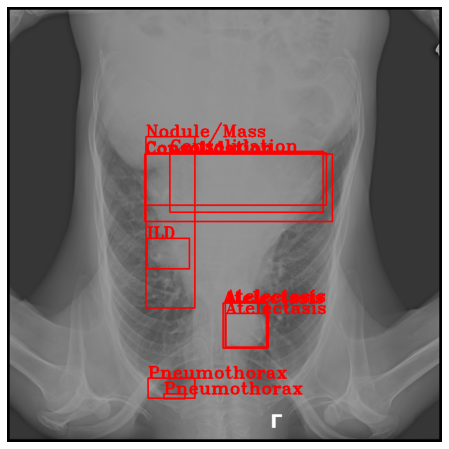

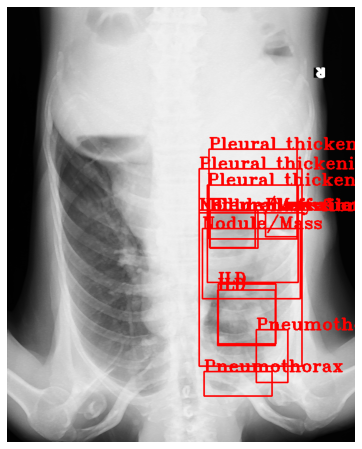

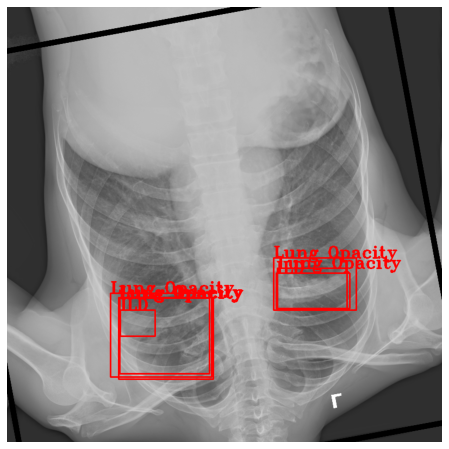

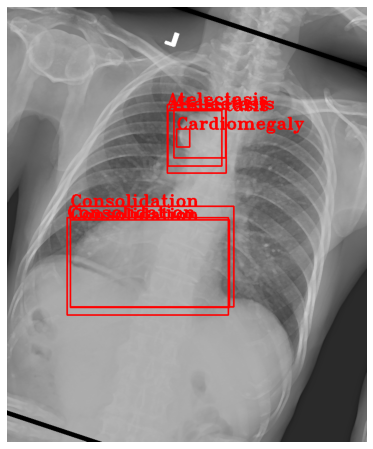

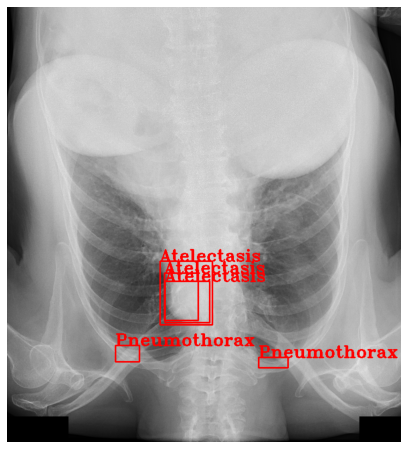

In [12]:
# Train dataset sample
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

for number in random.sample([1,2,3,4,5],5):
  boxes = targets[number]['boxes'].cpu().numpy().astype(np.int32)
  img = images[number].permute(1,2,0).cpu().numpy()
  labels= targets[number]['labels'].cpu().numpy().astype(np.int32)
  fig, ax = plt.subplots(1, 1, figsize=(16, 8))

  for i in range(len(boxes)):
      img = cv2.rectangle(img,(boxes[i][0]+paddingSize,boxes[i][1]+paddingSize),(boxes[i][2]+paddingSize,boxes[i][3]+paddingSize),(255,0,0),2)
      #print(le.inverse_transform([labels[i]-1])[0])
      #print(label_to_name(labels[i]), (int(boxes[i][0]), int(boxes[i][1])))
      img = cv2.putText(img, label_to_name(labels[i]), (int(boxes[i][0]), int(boxes[i][1])), cv2.FONT_HERSHEY_TRIPLEX,1, (255,0,0), 2, cv2.LINE_AA)

  ax.set_axis_off()
  ax.imshow(img)

In [13]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

REPLICAS: 1


### preparation for Model

In [14]:
train  =  pd.read_csv("../input/vinbigdata-chest-xray-abnormalities-detection/train.csv")
test = pd.read_csv('../input/vinbigdata-chest-xray-abnormalities-detection/sample_submission.csv')

train_dir256 = "../input/vinbigdata-chest-xray-resized-png-256x256/train"
test_dir256 = "../input/vinbigdata-chest-xray-resized-png-256x256/test"


train['image_png'] = train.image_id+'.png'
test['image_png'] = test.image_id+'.png'

IMAGE_SIZE256 = [256, 256] 
BATCH_SIZE = 32  
EPOCHS = 1
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)

In [15]:
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67914 entries, 0 to 67913
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_id    67914 non-null  object 
 1   class_name  67914 non-null  object 
 2   class_id    67914 non-null  int64  
 3   rad_id      67914 non-null  object 
 4   x_min       36096 non-null  float64
 5   y_min       36096 non-null  float64
 6   x_max       36096 non-null  float64
 7   y_max       36096 non-null  float64
 8   image_png   67914 non-null  object 
dtypes: float64(4), int64(1), object(4)
memory usage: 4.7+ MB
None


,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,image_png
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,50a418190bc3fb1ef1633bf9678929b3.png
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,21a10246a5ec7af151081d0cd6d65dc9.png
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,9a5094b2563a1ef3ff50dc5c7ff71345.png
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,051132a778e61a86eb147c7c6f564dfe.png
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,063319de25ce7edb9b1c6b8881290140.png


In [16]:
is_fold_train = train.groupby("image_png")["class_id"].agg(lambda s: 
(s == 14).sum()).reset_index().rename({
    "class_id": "num_normal_annotations"}, axis=1)
is_fold_train.head()

def change(x):
    if (x==3):
        x=1
    return x

is_fold_train['target'] = is_fold_train['num_normal_annotations'].apply(lambda x: change(x))
is_fold_train.head()

,image_png,num_normal_annotations,target
0,000434271f63a053c4128a0ba6352c7f.png,3,1
1,00053190460d56c53cc3e57321387478.png,3,1
2,0005e8e3701dfb1dd93d53e2ff537b6e.png,0,0
3,0006e0a85696f6bb578e84fafa9a5607.png,3,1
4,0007d316f756b3fa0baea2ff514ce945.png,0,0


In [17]:
skfolds = StratifiedKFold(n_splits=5, 
                          random_state=42, 
                          shuffle = True)
    
for num_fold, (train_index, val_index) in enumerate(skfolds.split(is_fold_train, is_fold_train.target)):
    is_fold_train.loc[val_index, 'fold'] = int(num_fold)
    
is_fold_train['target'] = is_fold_train.target.astype('str')

print(is_fold_train.info())
is_fold_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   image_png               15000 non-null  object 
 1   num_normal_annotations  15000 non-null  int64  
 2   target                  15000 non-null  object 
 3   fold                    15000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 468.9+ KB
None


,image_png,num_normal_annotations,target,fold
0,000434271f63a053c4128a0ba6352c7f.png,3,1,0.0
1,00053190460d56c53cc3e57321387478.png,3,1,3.0
2,0005e8e3701dfb1dd93d53e2ff537b6e.png,0,0,0.0
3,0006e0a85696f6bb578e84fafa9a5607.png,3,1,3.0
4,0007d316f756b3fa0baea2ff514ce945.png,0,0,1.0


### Data Generation of testing and training

In [19]:
datagen_train = ImageDataGenerator(
                        rotation_range=40,          
                        width_shift_range=0.2,   
                        height_shift_range=0.2,  
                        zoom_range=0.2,           
                        horizontal_flip=True,     
                        vertical_flip=False
                                   )     

datagen_test =  ImageDataGenerator(validation_split = 0.2)

In [20]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

### Model

In [21]:
with strategy.scope(): 

    class MyModel(Model):
        def __init__(self, appl, training=True):
            super(MyModel, self).__init__()
            self.d1_0 = tf.keras.applications.EfficientNetB0(
                input_shape=(*IMAGE_SIZE256, 3),
                weights='imagenet', pooling='avg', 
                include_top=False)
            
            self.d1_1 = tf.keras.applications.DenseNet121(
                input_shape=(*IMAGE_SIZE256, 3),
                weights=None, pooling='max') 
                                                           
            self.d2 = tf.keras.layers.Dense(150, activation='relu')
            self.d3 = tf.keras.layers.Dense(2, activation='sigmoid')
            self.dropout = tf.keras.layers.Dropout(0.15)
            
     
            self.training = training
            self.appl = appl

       
        def call(self, x):
    
            if self.appl:
                x = self.d1_0(x)
            else:
               
                x = self.d1_1(x)
            
            if self.training:
                x = self.dropout(x)
            x = self.d2(x)
            return self.d3(x)
    
    
model1 = MyModel(appl=True)
model2 = MyModel(appl=False)

model1.compile(
        optimizer = OPTIMIZER,
        loss = "binary_crossentropy",
        metrics = [tf.keras.metrics.BinaryAccuracy()]
    )

model2.compile(
        optimizer = OPTIMIZER,
        loss = "binary_crossentropy",
        metrics = [tf.keras.metrics.BinaryAccuracy()]
    )

In [22]:
loss_history = [] 
val_loss_history = []

binary_accuracy_history = []
val_binary_accuracy_history = []

### Training Part

In [23]:
for fold_n in range(5): 
    print('Fold #{}'.format(fold_n+1))
    
    train_data = is_fold_train[is_fold_train.fold != fold_n]
    val_data = is_fold_train[is_fold_train.fold == fold_n] 
    
    train_dataset = datagen_train.flow_from_dataframe(
        train_data,                                              
        directory = train_dir256,
        subset = "training",
        x_col = "image_png",
        y_col = "target",
        shuffle=True,
        batch_size=BATCH_SIZE)
            
            

    valid_dataset = datagen_test.flow_from_dataframe(
        val_data,
        directory = train_dir256,
        subset = "validation",
        x_col = "image_png",
        y_col = "target",
        shuffle=True,
        batch_size=BATCH_SIZE)
    
    model_fit = model1.fit(train_dataset, validation_data=valid_dataset, epochs=EPOCHS) 
    
    loss_history.append(model_fit.history['loss'])
    val_loss_history.append(model_fit.history['val_loss'])
    binary_accuracy_history.append(model_fit.history['binary_accuracy'])
    val_binary_accuracy_history.append(model_fit.history['val_binary_accuracy'])
    
    
lh = [item for sublist in loss_history for item in sublist]
vlh = [item for sublist in val_loss_history for item in sublist]

bah = [item for sublist in binary_accuracy_history for item in sublist]
vbah = [item for sublist in val_binary_accuracy_history for item in sublist]

Fold #1
Found 12000 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.
375/375 [==============================] - 239s 612ms/step - loss: 0.3638 - binary_accuracy: 0.8340 - val_loss: 0.2020 - val_binary_accuracy: 0.9175
Fold #2
Found 12000 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.
375/375 [==============================] - 232s 620ms/step - loss: 0.2230 - binary_accuracy: 0.9093 - val_loss: 0.2219 - val_binary_accuracy: 0.9150
Fold #3
Found 12000 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.
375/375 [==============================] - 230s 614ms/step - loss: 0.2041 - binary_accuracy: 0.9195 - val_loss: 0.2897 - val_binary_accuracy: 0.8617
Fold #4
Found 12000 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.
375/375 [========================

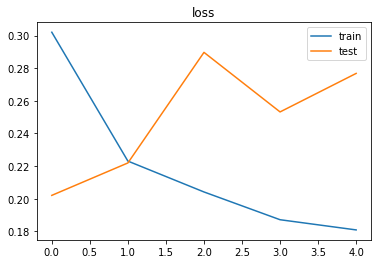

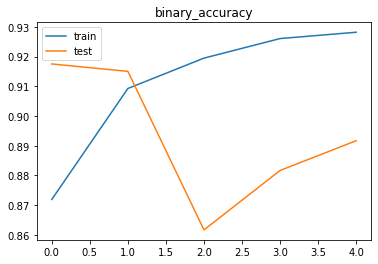

In [24]:
plt.plot(lh, label='train')
plt.plot(vlh, label='test')
plt.title('loss')
plt.legend()
plt.show()
plt.plot(bah, label='train')
plt.plot(vbah, label='test')
plt.title('binary_accuracy')
plt.legend()
plt.show()